In [1]:
%%capture
!wget https://www.dropbox.com/s/gb0lm94weq5u61b/fake%20reviews%20dataset.csv?dl=0
import pandas as pd
import numpy as np 

In [2]:
data = pd.read_csv("/content/fake reviews dataset.csv?dl=0")

In [3]:
print("Shape of data : ",data.shape)
print("Columns : ",list(data.columns))

Shape of data :  (40432, 4)
Columns :  ['category', 'rating', 'label', 'text_']


In [4]:
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [5]:
data[data['category'] == 'Books_5'][data['rating']==1.0]['label'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


CG    90
OR    77
Name: label, dtype: int64

Even 1 star ratings are being generated by the computer which is more than original

In [6]:
print(f"reviews for each rating : \n{data['rating'].value_counts()}")

reviews for each rating : 
5.0    24559
4.0     7965
3.0     3786
1.0     2155
2.0     1967
Name: rating, dtype: int64


OR(1) = Original reviews (presumably human created and authentic)

CG(0) = Computer-generated fake reviews.

In [7]:
categories = data['category'].unique()
print(categories)

['Home_and_Kitchen_5' 'Sports_and_Outdoors_5' 'Electronics_5'
 'Movies_and_TV_5' 'Tools_and_Home_Improvement_5' 'Pet_Supplies_5'
 'Kindle_Store_5' 'Books_5' 'Toys_and_Games_5'
 'Clothing_Shoes_and_Jewelry_5']


In [8]:
## working on kindle store data only for now 
%%capture
ks_data = data[data['category']=='Kindle_Store_5']
ks_data.reset_index(inplace=True)


ks_data.drop(['category','index'], axis = 1,inplace=True)

review_type = []

for x in ks_data['label']:
  if x == 'OR':
    review_type.append(1)
  else:
    review_type.append(0)

In [9]:
%%capture
ks_data.drop(['label'], axis = 1,inplace=True)
ks_data['review'] = review_type

In [10]:
ks_data

,rating,text_,review
0,5.0,This book I can't wait for more by this author...,0
1,5.0,Love this series cant wait for more by this au...,0
2,5.0,Read the books 2 time reading. The characters ...,0
3,4.0,very enjoyable. I would recommend this book to...,0
4,5.0,Great story can't wait for more. The character...,0
...,...,...,...
4725,3.0,(Source: I receieved a digital copy of this bo...,1
4726,5.0,"This is a beautifully written, sweet, and roma...",0
4727,4.0,"When a lie gets blown out of proportion, could...",1
4728,5.0,I received a copy of this book in exchange for...,0


This is preprocessed data that contains only Kindle Store reviews 

# Applying NLP

---
---

In [11]:
%%capture
!pip install nltk
!pip install contractions

import contractions
import re
import nltk

In [12]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [13]:
lemma = WordNetLemmatizer()

In [14]:
def apply_NLP(x):
  x = contractions.fix(x)
  x = x.lower()
  x = re.sub(r'\d+','',x)
  x = re.sub(r'[^\w\s]', '', x)
  x = word_tokenize(x)
  x = [w for w in x if not w in stopwords.words()]
  x = [ lemma.lemmatize(w, pos = "v") for w in x]
  x = [ lemma.lemmatize(w, pos = "n") for w in x]
  for i in x:
    if(len(i)==1):
      x.remove(i)
  x = ' '.join(x)
  return x

####  We choose the dataset size fo reviews to be 600 reviews, where both the categories CG and OR have almost equal proportion.

In [15]:
# dataset size
size = 600
short_ks_data = ks_data[:size]

In [16]:
short_review = short_ks_data['review']

In [17]:
x = short_ks_data['text_']
x = np.array(x) 

In [18]:
for i in range(x.shape[0]):
  x[i] = apply_NLP(x[i])

In [19]:
x = [i.split() for i in x]

## Generating required dictionaries

In [20]:
# color to be blue for OR and red for CG
Colors_dict = {}

for i in range(0,size):
  if ks_data['review'][i] == 1 :
    Colors_dict[i] = 'blue'
  else:
    Colors_dict[i] = 'red'

In [21]:
# Generate all dictionaries
BOW_dict = {}
c_t = []

In [22]:
for j in range(len(x)):
  label = j
  BOW_dict[label] = x[j]  

  for k in x[j]:
      c_t.append(k) 

In [23]:
threshold = 35

def find_common_with_thresh2(a,b,t):
  if(len(a)>0 and len(b)>0):
      res = len(set(a) & set(b)) / float(len(set(a) | set(b))) * 100
      if(res>=threshold):
        return  len(set(a) & set(b))
      else:
        return 0
  else:
    return 0

# Graph Generation

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()
for i in BOW_dict:
  G.add_node(i)

In [25]:
nx.set_node_attributes(G, Colors_dict, name="color")
node_color = list(Colors_dict.values())

In [26]:
for i in BOW_dict:
  for y in BOW_dict:
    if(i!=y):
      t = find_common_with_thresh2(BOW_dict[i],BOW_dict[y],(i,y))
      if(t != 0):
        G.add_edge(i,y,weight=t)

Network Density:  0.005804117974401781


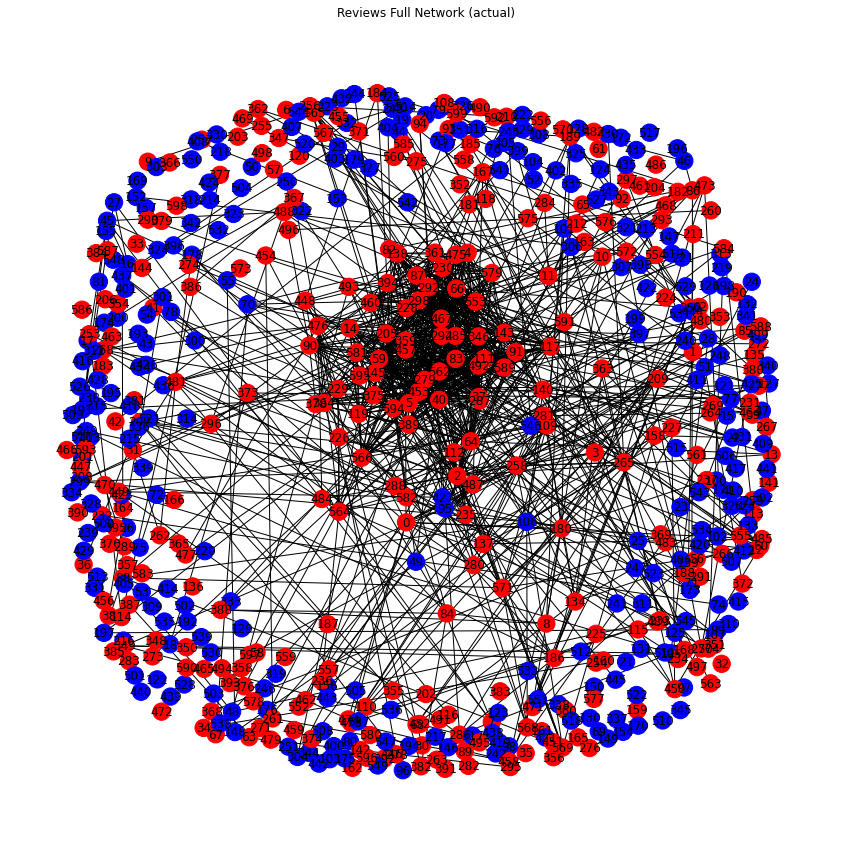

In [27]:
plt.figure(figsize=(15,15))
plt.title("Reviews Full Network (actual)")
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw(G, pos,with_labels=True, node_color=node_color)
print("Network Density: ", nx.density(G))

Here red highlights actual computer generated reviews and blue highlights original reviews.

## Clustering Algorithms Implemented


---



---



In [28]:
def get_common(x,y):
  return len(list(set(x)&set(y)))

In [29]:
print(get_common(BOW_dict[0],BOW_dict[1]))

3


In [30]:
size = len(BOW_dict)
M = np.zeros((size,size))

for i in range(size):
  for j in range(size):
    t = get_common(BOW_dict[i],BOW_dict[j])
    M[i][j] = t

fractional_row = M[0]/np.max(M[0])
for a in range(1,np.shape(M)[0]):
  temp = M[a]/np.max(M[a])
  fractional_row = np.vstack((fractional_row,temp))

M = fractional_row
np.fill_diagonal(M,0)

### 1. K-Means

In [31]:
import time
begin = time.time()

from sklearn.cluster import KMeans
k_cluster = 2
KM = KMeans(k_cluster)
KM.fit(M)
KM_Results = KM.labels_

KM_classes = [[] for i in range(k_cluster)]
for i in range(KM_Results.shape[0]):
  v = KM_Results[i]
  KM_classes[v].append(i)

for i in range(len(KM_classes)):
  print("Class ",i," -- ",KM_classes[i])

end = time.time()
time_KMeans = end-begin

Class  0  --  [1, 6, 7, 13, 15, 16, 17, 19, 20, 21, 23, 29, 30, 32, 33, 34, 36, 38, 39, 41, 42, 50, 52, 54, 58, 61, 63, 69, 72, 75, 78, 80, 81, 85, 89, 96, 97, 100, 103, 107, 110, 115, 118, 122, 123, 125, 126, 127, 128, 130, 131, 132, 133, 135, 136, 139, 141, 144, 147, 150, 151, 153, 154, 155, 157, 159, 160, 161, 162, 163, 165, 166, 169, 170, 171, 174, 175, 176, 177, 179, 181, 184, 190, 192, 194, 195, 196, 200, 201, 202, 203, 204, 206, 208, 211, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 231, 238, 239, 240, 241, 242, 245, 246, 247, 248, 250, 251, 254, 255, 257, 260, 263, 264, 267, 269, 273, 274, 275, 277, 282, 283, 284, 290, 291, 296, 300, 302, 303, 305, 308, 309, 310, 312, 313, 314, 315, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 333, 334, 335, 336, 337, 338, 339, 340, 341, 343, 344, 345, 347, 348, 350, 352, 353, 354, 355, 356, 357, 358, 360, 362, 365, 366, 370, 371, 374, 378, 381, 383, 384, 385, 387, 390, 391, 395, 396, 398, 400, 407, 

Colors Choosen are:  ['olive', 'yellow']


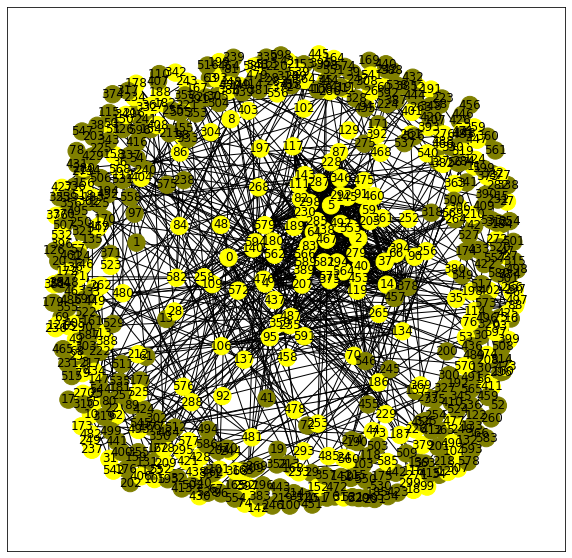

In [32]:
# Get random colors
import random
colors = ["green","yellow","cyan","red","orange","brown","blue","magenta","purple","olive","gray","violet","lime"]
choosen_colors = random.sample(colors, k_cluster)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(KM_classes)):
    if(i in KM_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)

plt.show()

In [33]:
from networkx import density

In [34]:
density(G)

0.005804117974401781

In [35]:
count = 0

## assume KM_classes[0] have review value 0 , ie, they are fake
for i in KM_classes[1]:
  if short_review[i] ==0:
    count+=1

# accuracy of fake detection
print(f"count : {count}")
print(count/(size/2))
print(f"false pos : {int(len(KM_classes[0]))-count}")

count : 184
0.6133333333333333
false pos : 143


### 2. Gaussian Mixture

In [36]:
import time
begin = time.time()
from sklearn.mixture import GaussianMixture

GM_clusters = 2
GM = GaussianMixture(n_components = GM_clusters)
GM.fit(M)
GM_Results = GM.predict(M)

GM_classes = [[] for i in range(GM_clusters)]
for i in range(GM_Results.shape[0]):
  v = GM_Results[i]
  GM_classes[v].append(i)

for i in range(len(GM_classes)):
  print("Class ",i," -- ",GM_classes[i])

end = time.time()
time_GM = end-begin

Class  0  --  [0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 14, 18, 22, 24, 25, 26, 27, 28, 31, 35, 37, 40, 43, 44, 45, 46, 47, 48, 49, 51, 53, 55, 56, 57, 59, 60, 62, 64, 65, 66, 67, 68, 70, 71, 73, 74, 76, 77, 79, 82, 83, 84, 86, 87, 88, 90, 91, 92, 93, 94, 95, 98, 99, 101, 102, 104, 105, 106, 108, 109, 111, 112, 113, 114, 116, 117, 119, 120, 121, 124, 129, 134, 137, 138, 140, 142, 143, 145, 146, 148, 149, 152, 156, 158, 164, 167, 168, 172, 173, 178, 180, 182, 183, 185, 186, 187, 188, 189, 191, 193, 197, 198, 199, 205, 207, 209, 210, 212, 221, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 243, 244, 249, 252, 253, 256, 258, 259, 261, 262, 265, 266, 268, 270, 271, 272, 276, 278, 279, 280, 281, 285, 286, 287, 288, 289, 292, 293, 294, 295, 297, 298, 299, 301, 304, 306, 307, 311, 316, 332, 342, 346, 349, 351, 359, 361, 363, 364, 367, 368, 369, 372, 373, 375, 376, 377, 379, 380, 382, 386, 388, 389, 392, 393, 394, 397, 399, 401, 402, 403, 404, 405, 406, 408, 411, 421, 425, 427, 428, 430, 434, 

Colors Choosen are:  ['orange', 'blue']


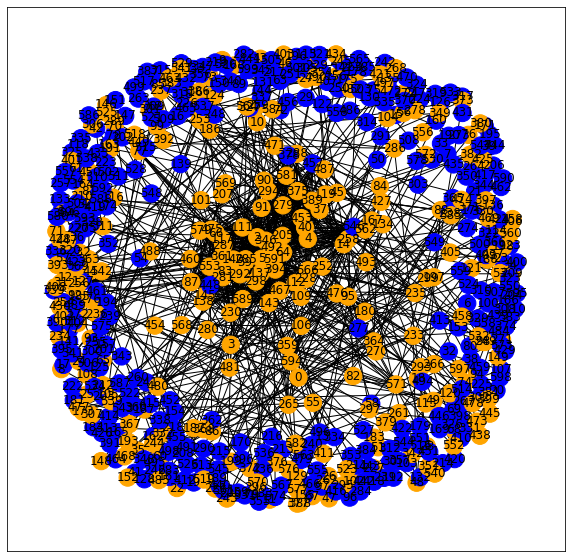

In [37]:
# Get random colors
import random
colors = ["green","yellow","cyan","red","orange","brown","blue","magenta","purple","olive","gray","violet","lime"]
choosen_colors = random.sample(colors, GM_clusters)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(GM_classes)):
    if(i in GM_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)
plt.show()

In [38]:
density(G)

0.005804117974401781

In [39]:
len(GM_classes[0])

274

In [40]:
short_review=list(short_review)

print(short_review)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [41]:
count = 0

## assume GM_classes[0] have review value 0 , ie, they are fake
for i in GM_classes[0]:
  if short_review[i] ==0:
    count+=1

# accuracy of fake detection
print(count/(size/2))

0.6166666666666667


### 3. Heirarchical clustering

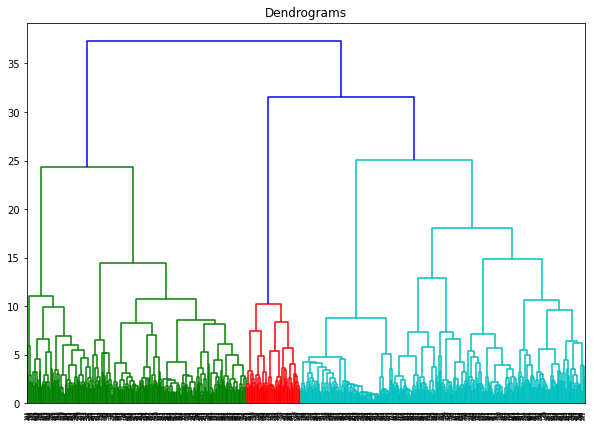

In [42]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(M, method='ward'))

## Community Detection

In [43]:
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)

In [44]:
print(f"number of communities: {len(communities)}")

number of communities: 350


In [45]:
for i,c in enumerate(communities): # Loop through the list of communities
  if i < 4: 
    print('Class '+str(i)+':', list(c)) # Print out the classes and their members

Class 0: [0, 1, 514, 3, 259, 258, 261, 265, 266, 12, 272, 18, 280, 24, 281, 288, 36, 297, 299, 304, 48, 306, 51, 55, 311, 568, 569, 571, 68, 73, 332, 77, 82, 595, 85, 88, 92, 93, 94, 95, 359, 106, 109, 368, 369, 112, 372, 373, 124, 134, 135, 137, 394, 140, 148, 406, 411, 156, 158, 427, 173, 430, 180, 437, 187, 189, 449, 198, 454, 458, 207, 464, 209, 468, 471, 473, 474, 478, 480, 485, 233, 237, 497, 243, 252]
Class 1: [256, 519, 7, 138, 523, 143, 16, 145, 27, 287, 39, 296, 553, 298, 45, 574, 191, 320, 579, 584, 201, 460, 589, 210, 467, 83, 87, 346, 475, 98, 228, 230, 488, 361, 111, 114, 117, 247, 377, 253]
Class 2: [2, 4, 5, 389, 13, 14, 399, 274, 403, 279, 285, 546, 292, 37, 294, 40, 562, 566, 59, 64, 66, 453, 581, 457, 588, 205, 119, 90, 91, 235, 492, 375, 378]
Class 3: [397, 273, 404, 30, 168, 41, 301, 46, 184, 570, 445, 448, 197, 582, 71, 585, 594, 84, 469, 86, 476, 221, 477, 99, 484, 104, 107, 364, 238, 371, 376, 382]


In [46]:
comm = list(communities[2])

count = 0

for i in comm:
  if short_review[i] ==0:
    count+=1

# accuracy of fake detection
print(count/(size/2))


0.1
